In [15]:
# Dataset
from hml.datasets import load_dataset
from sklearn.model_selection import train_test_split
# Approaches
from hml.approaches import CutAndCount as CBA
from hml.approaches import GradientBoostedDecisionTree as BDT
from hml.approaches import ToyMultilayerPerceptron as MLP
# Evaluation
from keras.metrics import Accuracy, AUC
from sklearn.metrics import roc_curve
from hml.metrics import MaxSignificance, RejectionAtEfficiency
from collections import defaultdict
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
# Save and load
from hml.approaches import load_approach

In [2]:
dataset = load_dataset("./data/zjj_vs_qcd.npz")

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    dataset.samples, dataset.targets, test_size=0.3, random_state=42
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [4]:
approach1 = CBA()
approach1.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = approach1.fit(
    x_train,
    y_train,
    batch_size=len(x_train),
    validation_data=(x_val, y_val),
)

1/1 [==============================] - 2s 2s/step - loss: 4.0295 - accuracy: 0.7500 - val_loss: 4.9923 - val_accuracy: 0.6903


In [5]:
approach2 = BDT()
approach2.compile(
    metrics=["accuracy"],
)
history = approach2.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
)

100/100 [==============================] - 1s 8ms/step - loss: 0.4396 - accuracy: 0.9239 - val_loss: 1.2479 - val_accuracy: 0.5841


In [6]:
approach3 = MLP()
approach3.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
approach3.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val),
)

Epoch 1/20
8/8 [==============================] - 1s 34ms/step - loss: 13.7174 - accuracy: 0.5575 - val_loss: 10.6973 - val_accuracy: 0.5841
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 10.3071 - accuracy: 0.5575 - val_loss: 8.0258 - val_accuracy: 0.5841
Epoch 3/20
8/8 [==============================] - 0s 19ms/step - loss: 7.5906 - accuracy: 0.5575 - val_loss: 5.7093 - val_accuracy: 0.5841
Epoch 4/20
8/8 [==============================] - 0s 21ms/step - loss: 5.1318 - accuracy: 0.5575 - val_loss: 3.5278 - val_accuracy: 0.5841
Epoch 5/20
8/8 [==============================] - 0s 19ms/step - loss: 2.8022 - accuracy: 0.5575 - val_loss: 1.2921 - val_accuracy: 0.5841
Epoch 6/20
8/8 [==============================] - 0s 22ms/step - loss: 0.8136 - accuracy: 0.6217 - val_loss: 0.5321 - val_accuracy: 0.8540
Epoch 7/20
8/8 [==============================] - 0s 19ms/step - loss: 0.4860 - accuracy: 0.8662 - val_loss: 0.5465 - val_accuracy: 0.7611
Epoch 8/20
8/8 [========

## Evaluation

| Name                           |      ACC |      AUC |   MaxSignificance |   RejectionAtEfficiency |
|--------------------------------|----------|----------|-------------------|-------------------------|
| cut_and_count                  | 0.729897 | 0.721404 |          10.1985  |                   1     |
| gradient_boosted_decision_tree | 0.876289 | 0.93703  |          13.3053  |                 125     |
| toy_multilayer_perceptron      | 0.610309 | 0.915157 |           6.78387 |                 249.999 |


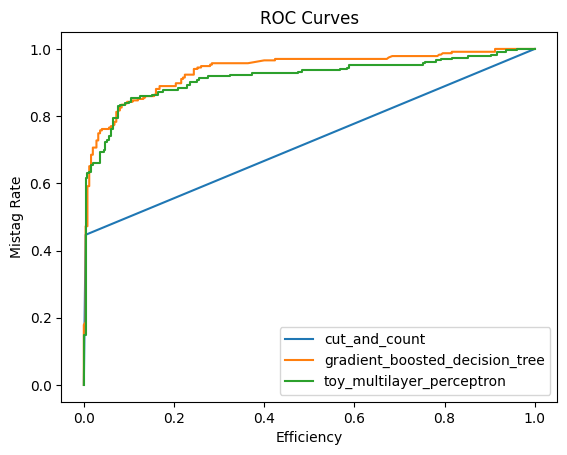

In [7]:
benchmark = defaultdict(list)
for approach in [approach1, approach2, approach3]:
    y_prob = approach.predict(x_test, verbose=0)
    y_pred = y_prob.argmax(axis=1)

    benchmark["Name"].append(approach.name)
    benchmark["ACC"].append(Accuracy()(y_test, y_pred).numpy())
    benchmark["AUC"].append(AUC()(y_test, y_prob[:, 1]).numpy())
    benchmark["MaxSignificance"].append(MaxSignificance()(y_test, y_prob[:, 1]).numpy())
    benchmark["RejectionAtEfficiency"].append(RejectionAtEfficiency(0.5)(y_test, y_prob[:, 1]).numpy())

    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    plt.plot(fpr, tpr, label=f"{approach.name}")

print(tabulate(benchmark, headers="keys", tablefmt="github"))

plt.title("ROC Curves")
plt.xlabel("Efficiency")
plt.ylabel("Mistag Rate")
plt.legend()
plt.show()

In [9]:
approach1.summary()
approach2.summary()
approach3.summary()

Model: "cut_and_count"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 10 (40.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 10 (40.00 Byte)
_________________________________________________________________
n_bins: 50
cuts:
  #1: x >= 78.3743
  #2: x <= 0.5286
  #3: x <= 2.7339
Model: "gradient_boosted_decision_tree"
- ccp_alpha: 0
- criterion: friedman_mse
- init: None
- learning_rate: 0.1
- loss: log_loss
- max_depth: 3
- max_features: None
- max_leaf_nodes: None
- min_impurity_decrease: 0
- min_samples_leaf: 1
- min_samples_split: 2
- min_weight_fraction_leaf: 0
- n_estimators: 100
- n_iter_no_change: None
- name: gradient_boosted_decision_tree
- random_state: None
- subsample: 1
- tol: 0.0001
- validation_fraction: 0.1
- verbose: 0
- warm_start: False
Model: "toy_multilayer_perceptron"
_________________________________________________________________
 Layer (type)      

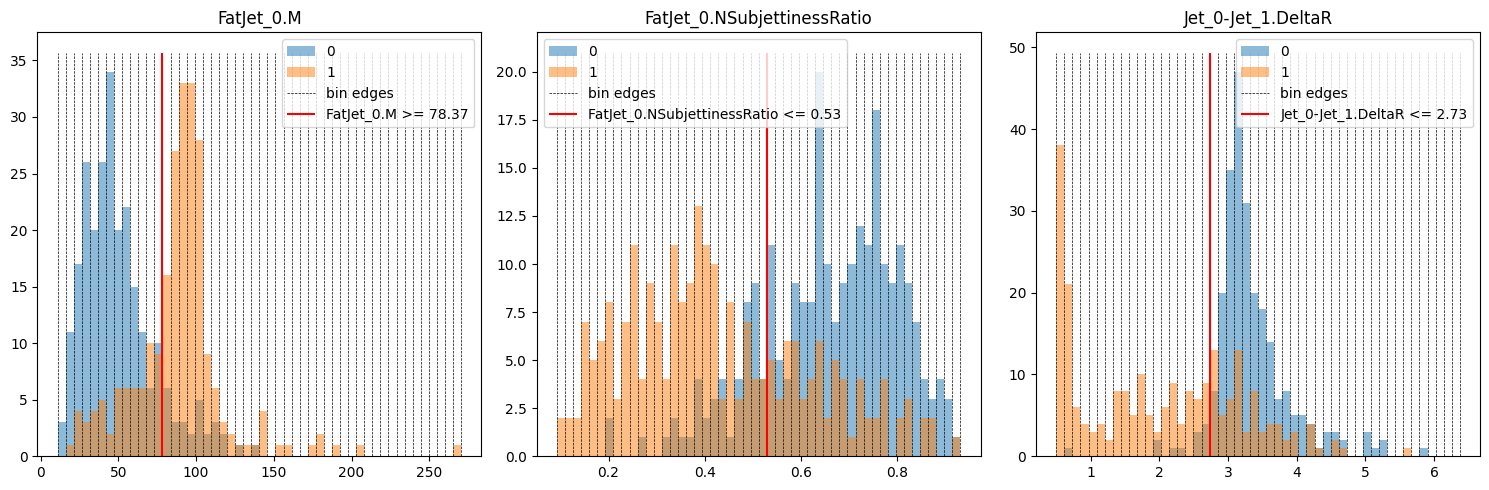

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index in range(x_train.shape[1]):
    case = approach1.cases[index]
    cuts = approach1.cuts[index]
    observable = dataset.feature_names[index]
    bin_edges = np.linspace(x_train[:, index].min(), x_train[:, index].max(), approach1.n_bins+1)

    axs[index].hist(x_test[:, index][y_test == 0], bins=bin_edges, alpha=0.5, label="0")
    axs[index].hist(x_test[:, index][y_test == 1], bins=bin_edges, alpha=0.5, label="1")

    y_min, y_max = axs[index].get_ylim()
    axs[index].vlines(bin_edges, y_min, y_max, color="k", ls="dashed", lw=0.5, label="bin edges")

    if case == 0:
        axs[index].vlines(cuts[0], y_min, y_max, color="r", label=f"{observable} <= {cuts[0]:.2f}")
    elif case == 1:
        axs[index].vlines(cuts[0], y_min, y_max, color="r", label=f"{observable} >= {cuts[0]:.2f}")
    elif case == 2:
        axs[index].vlines(cuts[0], y_min, y_max, color="r", label=f"{cuts[0]:.2f} <= {observable} <= {cuts[1]:.2f}")
        axs[index].vlines(cuts[1], y_min, y_max, color="r")
    else:
        axs[index].vlines(cuts[0], y_min, y_max, color="r", label=f"{observable} <= {cuts[0]:.2f} or {observable} >= {cuts[1]:.2f}")
        axs[index].vlines(cuts[1], y_min, y_max, color="r")
        
    axs[index].set_title(f"{observable}")
    axs[index].legend()

plt.tight_layout()
plt.show()

In [14]:
approach1.save("./checkpoints/CBA.keras")
approach2.save("./checkpoints/BDT.pickle")
approach3.save("./checkpoints/MLP.keras")

In [16]:
loaded_approach1 = load_approach("./checkpoints/CBA.keras")
loaded_approach2 = load_approach("./checkpoints/BDT.pickle")
loaded_approach3 = load_approach("./checkpoints/MLP.keras")

In [24]:
assert (approach1.cuts.numpy() == loaded_approach1.cuts.numpy()).all()
assert approach2.n_estimators_ == loaded_approach2.n_estimators_
assert approach3.count_params() == loaded_approach3.count_params()